import packages

In [1]:
import pandas as pd
import numpy as np
import math
from collections import Counter
import random
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score

build synthetic dataset

In [2]:
seed = 42
np.random.seed(seed)
random.seed(42)

#original loan amount
#credit score
#ltv
#vehicle_type
#number of late payments
#loan_default

In [3]:
min_loan = 4000
max_loan = 75000
n_loans = 1000

orig_loan_bal = []

for i in np.arange(0, n_loans, 1):
    orig_bal = np.random.randint(min_loan, max_loan)
    orig_bal = round(orig_bal, -2)
    orig_loan_bal.append(orig_bal)

In [4]:
min_ltv = 50
max_ltv = 120

orig_ltv = []

for i in orig_loan_bal:
    ltv = min_ltv + (i - min_loan) / (max_loan - min_loan) * (max_ltv - min_ltv)

    noise = np.random.normal(-40, 40)

    ltv = ltv + noise

    ltv = max(min_ltv, min(max_ltv, ltv))

    orig_ltv.append(round(ltv, 2))


In [5]:
min_score = 550
max_score = 850

orig_credit_score = []

for i, j in zip(orig_loan_bal, orig_ltv):
    if j > 100:
        score = min_score + (i - min_loan) / (max_loan - min_loan) * (max_score - min_score)
        noise = np.random.normal(-125, 55)
        score = score + noise
        orig_credit_score.append(round(max(min_score, min(max_score, score))))

    else:
        score = min_score + (i - min_loan) / (max_loan - min_loan) * (max_score - min_score)
        noise = np.random.normal(-70, 70)
        score = score + noise
        orig_credit_score.append(round(max(min_score, min(max_score, score))))

In [6]:
max_late_payments = 12

orig_late_payments = []

for i, j in zip(orig_credit_score, orig_ltv):
    # Create a "risk score" combining credit and LTV
    credit_risk = (max_score - i) / (max_score - min_score)  # 0-1, higher = riskier
    ltv_risk = (j - 50) / (120 - 50)  # 0-1, higher LTV = riskier
    
    # Combined risk (weight credit more heavily)
    combined_risk = (credit_risk * 0.8) + (ltv_risk * 0.2)  
    
    # Scale to late payment probability
    expected_late = combined_risk * 2
    
    # Add some randomness but keep it realistic
    late_payments = np.random.poisson(expected_late)  # Poisson for count data
    late_payments = min(max_late_payments, late_payments)  # Cap at 12
    
    orig_late_payments.append(late_payments)

In [7]:
vehicle_types = ['NEW', 'USED']
weight = [0.3, 0.7]

orig_vehicle_type = random.choices(vehicle_types, weights=weight, k=n_loans)

In [8]:
default = []

for loan, credit_score, ltv, late_payments, vehicle in zip(orig_loan_bal, orig_credit_score, orig_ltv, orig_late_payments, orig_vehicle_type):
    # Base default probability
    default_prob = 0.55  # Base 10% default rate

    # Increase probability for high LTV
    loan_factor = -0.067 * (loan - min_loan) / (max_loan - min_loan)
    credit_score_factor = -0.065 * (max_score - credit_score) / (max_score - min_score)

    ltv_factor = 0.05 * max(0, (ltv - 80) / 100)
    late_payments_factor = 0.020 * late_payments 
    vehicle_factor = -0.014 if vehicle == "NEW" else 0.01

    prob_default = default_prob + ltv_factor + loan_factor + credit_score_factor + late_payments_factor + vehicle_factor

    prob_default = min(0.95, max(0, prob_default))

    prob_default += np.random.normal(0.005, 0.10)


    default.append(prob_default)

In [9]:
binary_default = lambda x: 1 if x > 0.6 else 0

loan_data = pd.DataFrame({
    'original_loan_amount': orig_loan_bal,
    'credit_score': orig_credit_score,
    'ltv': orig_ltv,
    'vehicle_type': orig_vehicle_type,
    'late_payments': orig_late_payments,
    'loan_default': list(map(binary_default, default))
})

In [10]:
loan_data.loan_default.value_counts()

loan_default
0    831
1    169
Name: count, dtype: int64

In [11]:
# Check vehicle type vs default rates
print(loan_data.groupby('vehicle_type')['loan_default'].agg(['count', 'mean']))

              count      mean
vehicle_type                 
NEW             295  0.111864
USED            705  0.192908


In [12]:
# See if credit score and vehicle type are correlated
print("Average credit score by vehicle type:")
print(loan_data.groupby('vehicle_type')['credit_score'].mean())

# Check credit score distribution in defaults vs non-defaults
print("Credit score by default status:")
print(loan_data.groupby('loan_default')['credit_score'].agg(['mean', 'std']))

Average credit score by vehicle type:
vehicle_type
NEW     654.318644
USED    637.449645
Name: credit_score, dtype: float64
Credit score by default status:
                    mean        std
loan_default                       
0             643.971119  86.567943
1             634.828402  83.549957


Manual Tree Building

In [13]:
# Test potential splits to see which best separates defaults
print("Overall default rate:", loan_data['loan_default'].mean())
print("\n--- Testing Credit Score Splits ---")
print("Credit < 620:", round(loan_data[loan_data['credit_score'] < 620]['loan_default'].sum() / len(loan_data[loan_data['credit_score'] < 620]), 3))
print("Credit >= 620:", round(loan_data[loan_data['credit_score'] >= 620]['loan_default'].sum() / len(loan_data[loan_data['credit_score'] >= 620]), 3))

print("\n--- Testing Late Payment Splits ---") 
print("Late payments >= 3:", round(loan_data[loan_data['late_payments'] >= 3]['loan_default'].sum() / len(loan_data[loan_data['late_payments'] >= 3]), 3))
print("Late payments < 3:", round(loan_data[loan_data['late_payments'] < 3]['loan_default'].sum() / len(loan_data[loan_data['late_payments'] < 3]), 3))

print("\n--- Testing LTV Splits ---")
print("LTV >= 100:", round(loan_data[loan_data['ltv'] >= 100]['loan_default'].sum() / len(loan_data[loan_data['ltv'] >= 100]), 3))
print("LTV < 100:", round(loan_data[loan_data['ltv'] < 100]['loan_default'].sum() / len(loan_data[loan_data['ltv'] < 100]), 3))

Overall default rate: 0.169

--- Testing Credit Score Splits ---
Credit < 620: 0.181
Credit >= 620: 0.158

--- Testing Late Payment Splits ---
Late payments >= 3: 0.312
Late payments < 3: 0.149

--- Testing LTV Splits ---
LTV >= 100: 0.233
LTV < 100: 0.161


Decision Tree Building

In [14]:
#encode vehicle type
loan_data['vehicle_type_encoded'] = loan_data['vehicle_type'].map({'NEW': 0, 'USED': 1})


X = loan_data[['original_loan_amount', 'credit_score', 'ltv', 'late_payments', 'vehicle_type_encoded']]
y = loan_data['loan_default']

In [15]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [16]:
clf = DecisionTreeClassifier(max_depth = 4, random_state=seed)
clf.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,4
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [17]:
# Predict on the test set
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 0.82


Features: ['original_loan_amount', 'credit_score', 'ltv', 'late_payments', 'vehicle_type_encoded']
Tree depth: 4
Number of leaves: 16
                feature  importance
2                   ltv    0.268686
1          credit_score    0.245722
3         late_payments    0.203236
0  original_loan_amount    0.152187
4  vehicle_type_encoded    0.130170


Text(0.5, 1.0, 'Feature Importances')

<Figure size 1500x1000 with 0 Axes>

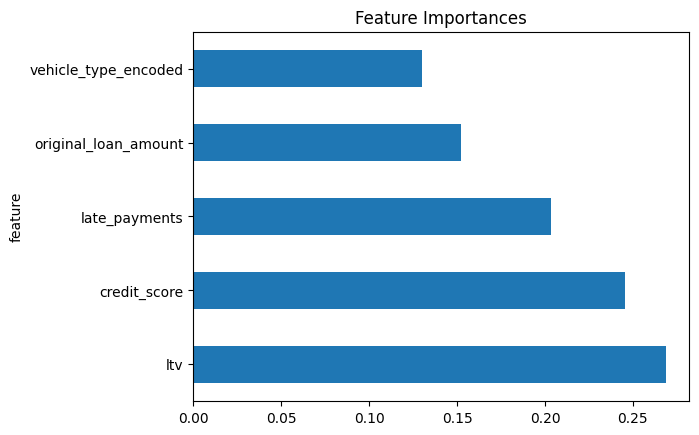

In [18]:
# Check what features you're actually using
print("Features:", X.columns.tolist())

# Look at the decision tree depth/complexity
print("Tree depth:", clf.get_depth())
print("Number of leaves:", clf.get_n_leaves())

# Check feature importances
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': clf.feature_importances_
}).sort_values('importance', ascending=False)
print(feature_importance)
plt.figure(figsize=(15, 10))
feature_importance.plot(kind='barh', x='feature', y='importance', legend=False)
plt.title('Feature Importances')

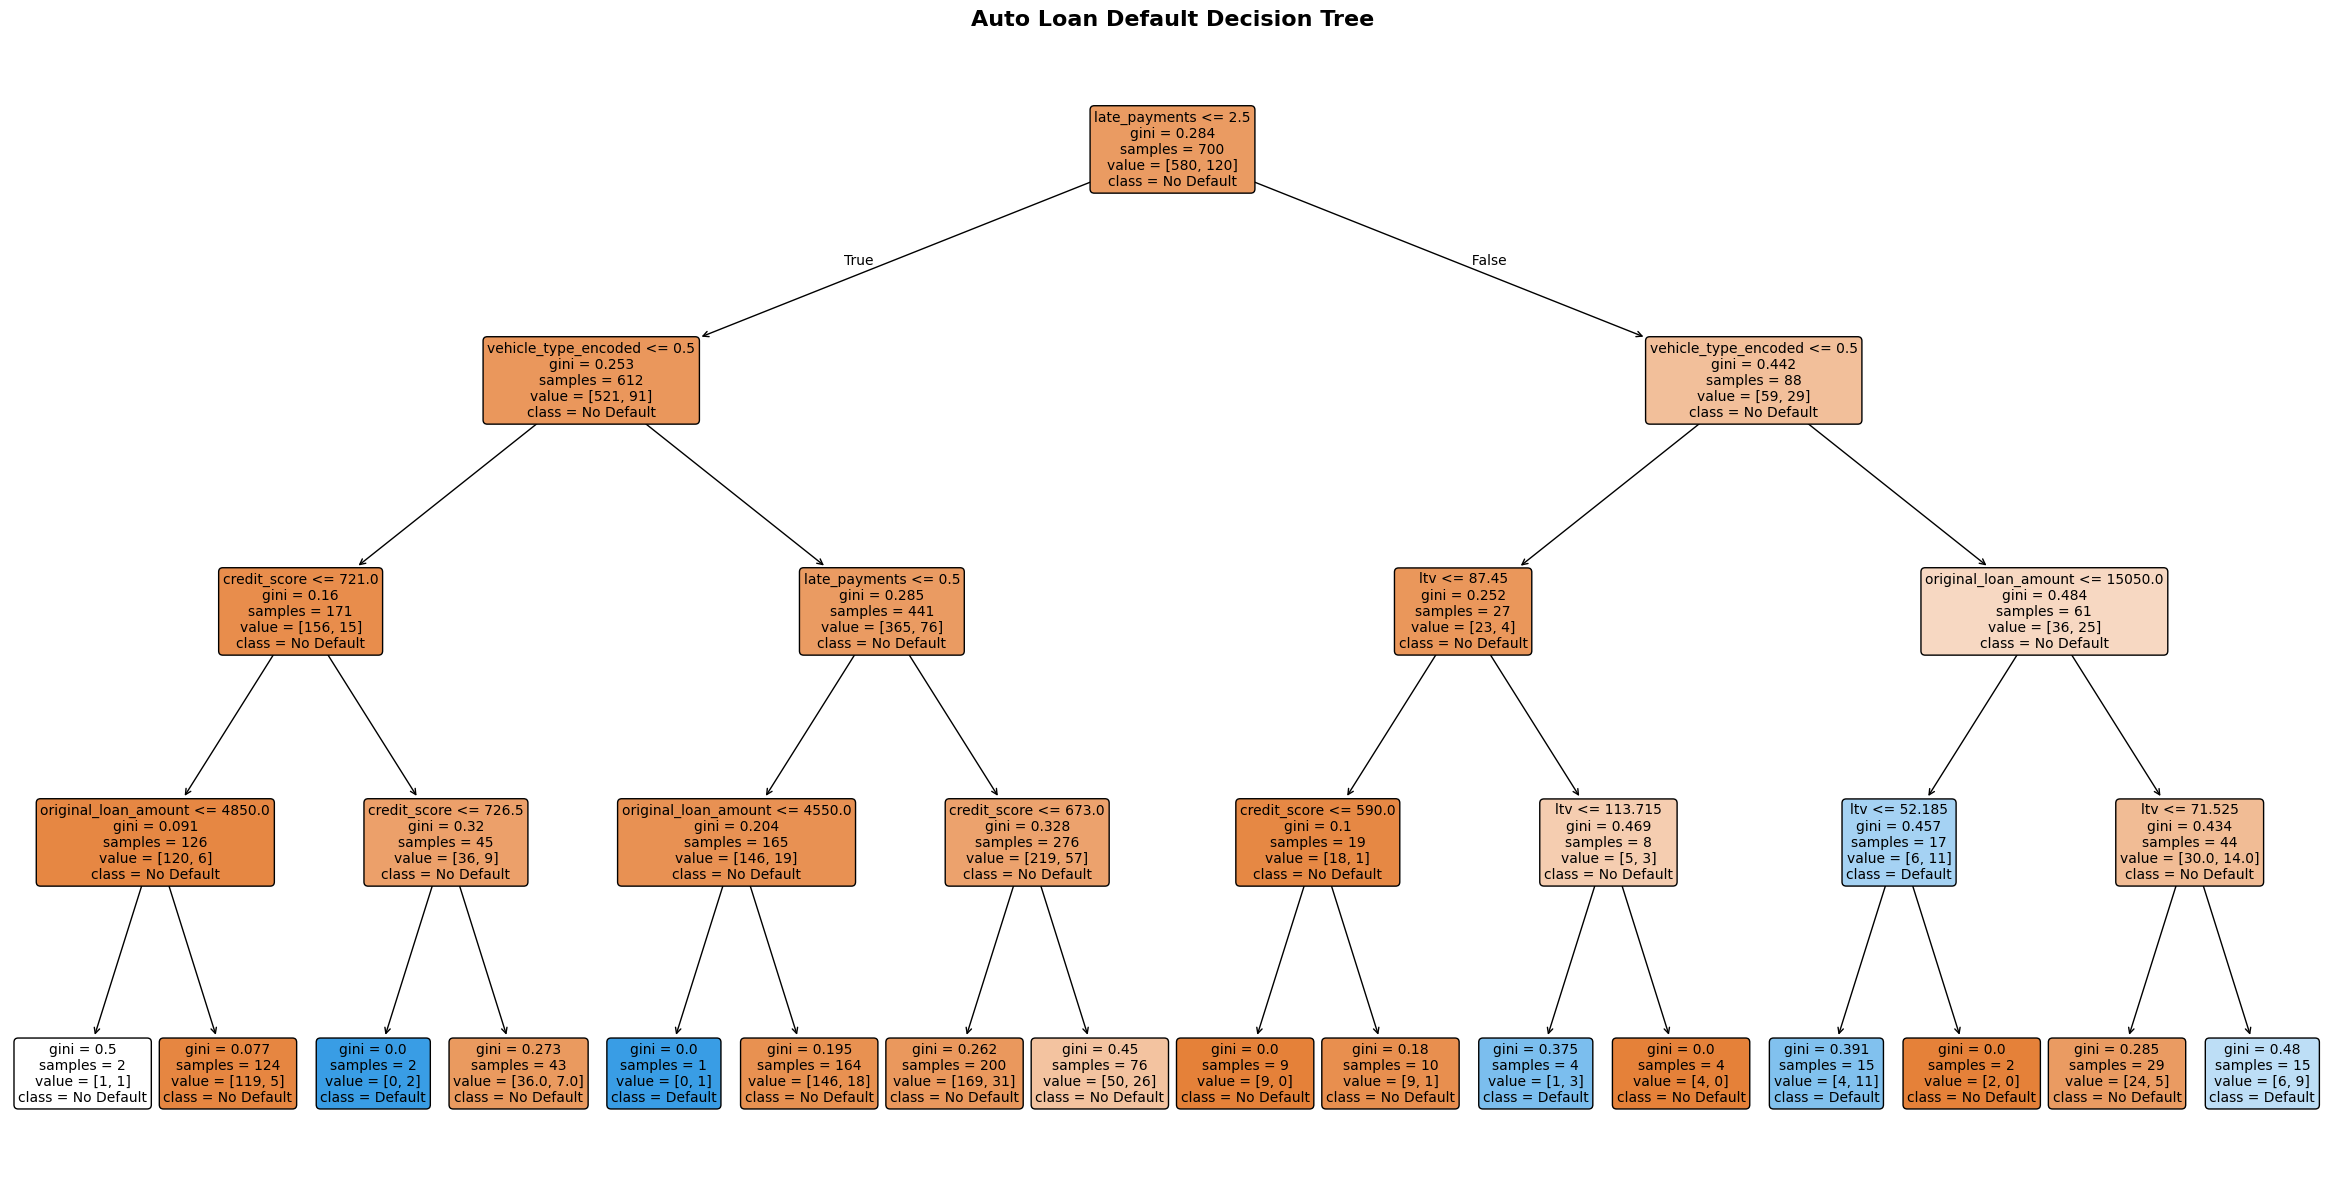

In [19]:
# Create a large, readable tree visualization
plt.figure(figsize=(30, 15))
plot_tree(clf, 
          feature_names=X.columns, 
          class_names=['No Default', 'Default'], 
          filled=True, 
          rounded=True,
          fontsize=10)
plt.title('Auto Loan Default Decision Tree', fontsize=16, fontweight='bold')
plt.show()

Hyperparameter Tuning

Max Depth: 1 | Accuracy: 0.84
Max Depth: 2 | Accuracy: 0.84
Max Depth: 3 | Accuracy: 0.83
Max Depth: 4 | Accuracy: 0.82
Max Depth: 5 | Accuracy: 0.83
Max Depth: 6 | Accuracy: 0.81
Max Depth: 7 | Accuracy: 0.78
Max Depth: 8 | Accuracy: 0.79


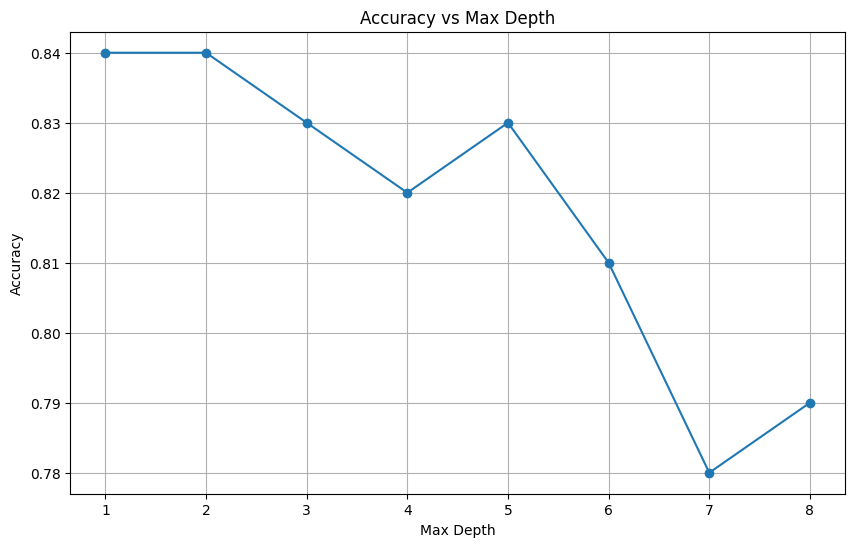

In [20]:
# max_depth can be tuned to control overfitting/underfitting
# Experiment with different max_depth values and observe accuracy and tree complexity

m_depth = range(1,9)

max_depth_list = []
accuracy_list = []

for i in m_depth:
    #establish model
    clf = DecisionTreeClassifier(max_depth = i, random_state=seed)
    #fit model
    clf.fit(X_train, y_train)

    # Predict on the test set
    y_pred = clf.predict(X_test)

    # Calculate accuracy
    accuracy = round(accuracy_score(y_test, y_pred), 2)
    print(f"Max Depth: {i} | Accuracy: {accuracy}")
    max_depth_list.append(i)
    accuracy_list.append(accuracy)

    #1 to 5 is actually optimal
plt.figure(figsize=(10, 6))
plt.plot(max_depth_list, accuracy_list, marker='o')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Max Depth')
plt.grid(True)
plt.show()

In [21]:
#max_depth: range(1,6)           # 8 values
#min_samples_split: np.arange(2, 20, 1)    # 18 values  
#min_samples_leaf: np.arange(1, 21, 1)     # 20 values
#max_features: np.arange(1, 6, 1)          # 4 values

Min Samples Split: 2 | Accuracy: 0.74
Min Samples Split: 3 | Accuracy: 0.75
Min Samples Split: 4 | Accuracy: 0.73
Min Samples Split: 5 | Accuracy: 0.74
Min Samples Split: 6 | Accuracy: 0.74
Min Samples Split: 7 | Accuracy: 0.74
Min Samples Split: 8 | Accuracy: 0.74
Min Samples Split: 9 | Accuracy: 0.76
Min Samples Split: 10 | Accuracy: 0.76
Min Samples Split: 11 | Accuracy: 0.76
Min Samples Split: 12 | Accuracy: 0.77
Min Samples Split: 13 | Accuracy: 0.77
Min Samples Split: 14 | Accuracy: 0.77
Min Samples Split: 15 | Accuracy: 0.77
Min Samples Split: 16 | Accuracy: 0.76
Min Samples Split: 17 | Accuracy: 0.76
Min Samples Split: 18 | Accuracy: 0.76
Min Samples Split: 19 | Accuracy: 0.78
Min Samples Split: 20 | Accuracy: 0.78
Min Samples Split: 21 | Accuracy: 0.78
Min Samples Split: 22 | Accuracy: 0.78
Min Samples Split: 23 | Accuracy: 0.81
Min Samples Split: 24 | Accuracy: 0.81
Min Samples Split: 25 | Accuracy: 0.81
Min Samples Split: 26 | Accuracy: 0.81
Min Samples Split: 27 | Accuracy:

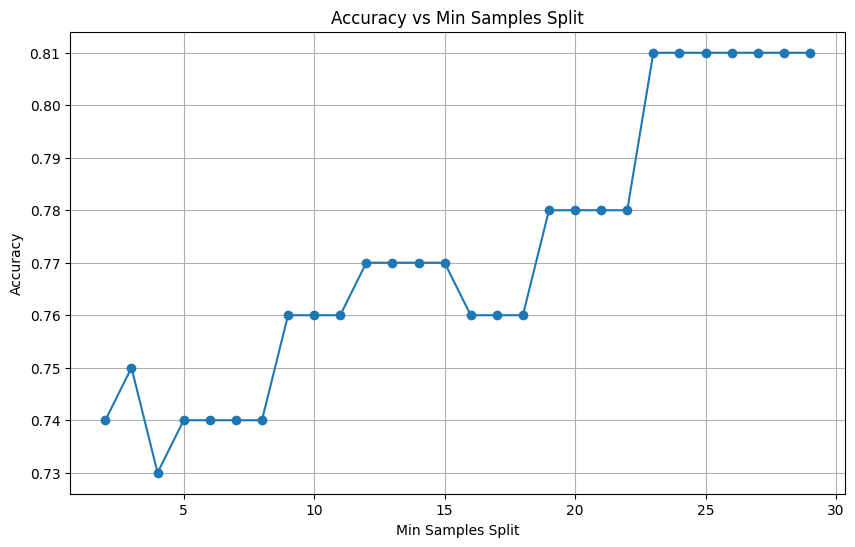

In [22]:
m_samples_split = np.arange(2, 30, 1) 

m_samples_split_list = []
accuracy_split_list = []

for i in m_samples_split:
    #establish model
    clf = DecisionTreeClassifier(min_samples_split = i, random_state=seed)
    #fit model
    clf.fit(X_train, y_train)

    # Predict on the test set
    y_pred = clf.predict(X_test)

    # Calculate accuracy
    accuracy = round(accuracy_score(y_test, y_pred), 2)
    print(f"Min Samples Split: {i} | Accuracy: {accuracy}")

    m_samples_split_list.append(i)
    accuracy_split_list.append(accuracy)

plt.figure(figsize=(10, 6))
plt.plot(m_samples_split_list, accuracy_split_list, marker='o')
plt.xlabel('Min Samples Split')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Min Samples Split')
plt.grid(True)
plt.show()

Min Samples Leaf: 1 | Accuracy: 0.74
Min Samples Leaf: 2 | Accuracy: 0.78
Min Samples Leaf: 3 | Accuracy: 0.76
Min Samples Leaf: 4 | Accuracy: 0.8
Min Samples Leaf: 5 | Accuracy: 0.81
Min Samples Leaf: 6 | Accuracy: 0.81
Min Samples Leaf: 7 | Accuracy: 0.81
Min Samples Leaf: 8 | Accuracy: 0.82
Min Samples Leaf: 9 | Accuracy: 0.81
Min Samples Leaf: 10 | Accuracy: 0.82
Min Samples Leaf: 11 | Accuracy: 0.82
Min Samples Leaf: 12 | Accuracy: 0.82
Min Samples Leaf: 13 | Accuracy: 0.81
Min Samples Leaf: 14 | Accuracy: 0.81
Min Samples Leaf: 15 | Accuracy: 0.81
Min Samples Leaf: 16 | Accuracy: 0.83
Min Samples Leaf: 17 | Accuracy: 0.82
Min Samples Leaf: 18 | Accuracy: 0.82
Min Samples Leaf: 19 | Accuracy: 0.82
Min Samples Leaf: 20 | Accuracy: 0.83
Min Samples Leaf: 21 | Accuracy: 0.83
Min Samples Leaf: 22 | Accuracy: 0.83
Min Samples Leaf: 23 | Accuracy: 0.83
Min Samples Leaf: 24 | Accuracy: 0.83
Min Samples Leaf: 25 | Accuracy: 0.82
Min Samples Leaf: 26 | Accuracy: 0.84
Min Samples Leaf: 27 |

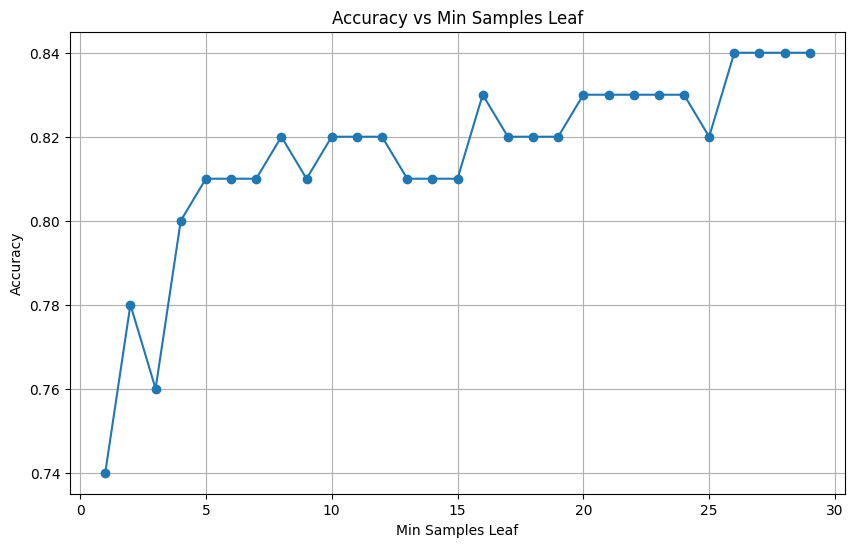

In [23]:
m_samples_leaf = np.arange(1, 30, 1) 

m_samples_leaf_list = []
accuracy_leaf_list = []

for i in m_samples_leaf:
    #establish model
    clf = DecisionTreeClassifier(min_samples_leaf = i, random_state=seed)
    #fit model
    clf.fit(X_train, y_train)

    # Predict on the test set
    y_pred = clf.predict(X_test)

    # Calculate accuracy
    accuracy = round(accuracy_score(y_test, y_pred), 2)
    print(f"Min Samples Leaf: {i} | Accuracy: {accuracy}")

    m_samples_leaf_list.append(i)
    accuracy_leaf_list.append(accuracy)

plt.figure(figsize=(10, 6))
plt.plot(m_samples_leaf_list, accuracy_leaf_list, marker='o')
plt.xlabel('Min Samples Leaf')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Min Samples Leaf')
plt.grid(True)
plt.show()

gridsearchCV method

In [24]:
# Define the hyperparameters and their potential values in a dictionary (param_grid)
param_grid = {
    'max_depth': range(1,9),
    'min_samples_split': np.arange(2, 30, 1),
    'min_samples_leaf': np.arange(1, 30, 1) 
}

clf = DecisionTreeClassifier(random_state=seed)

grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring='accuracy', # Choose an appropriate metric (e.g., 'accuracy', 'f1', 'neg_mean_squared_error')
    cv=5,               # Use 5-fold cross-validation (a common choice)
    verbose=1,          # Optional: controls the amount of logging output
    n_jobs=-1           # Optional: uses all available processor cores for parallel processing
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6496 candidates, totalling 32480 fits


,estimator,DecisionTreeC...ndom_state=42)
,param_grid,"{'max_depth': range(1, 9), 'min_samples_leaf': array([ 1, 2..., 27, 28, 29]), 'min_samples_split': array([ 2, 3..., 27, 28, 29])}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


In [27]:
# Print the best parameters
print(f"Best parameters found: {grid_search.best_params_}")

# Print the best cross-validation score
print(f"Best CV score: {round(grid_search.best_score_, 4)}")

# Access the best estimator (model) directly
best_model = grid_search.best_estimator_

# Evaluate the best model on the hold-out test set
test_score = round(best_model.score(X_test, y_test), 4)
print(f"Test set accuracy with best model: {test_score}")


Best parameters found: {'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best CV score: 0.83
Test set accuracy with best model: 0.8367
